## Distribution functions

In [3]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np



In [4]:
import utils.load_grid as lg
from utils.load_cmaps import *

In [5]:
pgrid_dir = "data/shared/pgrid_earth_gridtest_14"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

helps, hvars = lg.load_helpfiles(cases)
cvars = lg.load_cvars(cases)

Helpfiles:   0%|          | 0/96 [00:00<?, ?it/s]

Configs: 100%|██████████| 96/96 [00:00<00:00, 381.78it/s]


In [6]:
# https://stackoverflow.com/a/65972406
def _ecdf(a):
    a = np.sort(a)
    x, counts = np.unique(a, return_counts=True)
    cusum = np.cumsum(counts)
    return x, cusum / cusum[-1]

In [7]:
def ecdf_flat(dep_key, dep_lbl, logy=False):

    x, y = _ecdf(lg.access_hvars(hvars,dep_key,-1))

    fig,ax = plt.subplots(1,1)
    ax.plot(x, y, color='black', drawstyle='steps-post')
    ax.set_xlabel(dep_lbl)
    ax.set_ylabel("Count")
    plt.show()

### Plot eCDFs for different values of an independent variable

In [8]:
def ecdf_indep(dep_key,dep_lbl, indep_key,indep_lbl, logx=False, logy=False, logz=False):

    fig,ax = plt.subplots(1,1, figsize=(5,4))
    lw = 4
    al = 0.75

    # Get all values of indep variable used in grid
    indep_vals = cvars[indep_key]
    indep_vals = sorted(list(set(indep_vals)))

    # Setup cmap,norm
    if not logz:
        norm = mpl.colors.Normalize(vmin=np.amin(indep_vals), vmax=np.amax(indep_vals))
    else:
        norm = mpl.colors.LogNorm(vmin=np.amin(indep_vals), vmax=np.amax(indep_vals))
    cmap = sci_colormaps['roma']
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

    # Dependent variable values
    dep_vals = lg.access_hvars(hvars,dep_key,-1)
   
    for indep_val in indep_vals: # for each value of the independent variable, make ecdf plot
        dat = []
        for i in range(ncases):
            if np.isclose(cvars[indep_key][i], indep_val):
                dat.append(dep_vals[i])
        x, y = _ecdf(dat) 
        ax.plot(x, y, c=sm.to_rgba(indep_val),
                alpha=al, lw=lw, drawstyle='steps-post', label=str(indep_val))

    # finalise plot
    # ax.set_ylabel("Cumulative probability")
    ax.set_xlabel(dep_lbl)
    ax.legend(title=indep_lbl)
    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    plt.show()

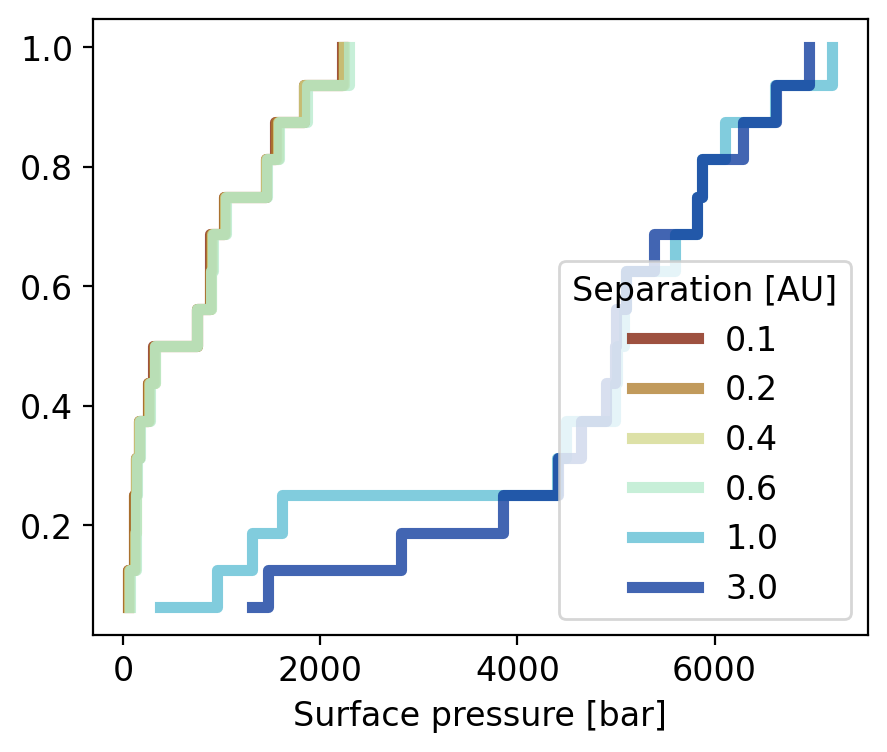

In [9]:
# x = "Time"; x_lbl = "Termination time [yr]"; logx=True
x,x_lbl = "P_surf", "Surface pressure [bar]"; logx=False

# z = "CH_ratio"; z_lbl = "C/H ratio"; logz=True
# z = "fO2_shift_IW"; z_lbl = "Oxygen fugacity"; logz=False
z =  "mean_distance"; z_lbl = "Separation [AU]"; logz=True

ecdf_indep(
    x,x_lbl,
    z,z_lbl,
    logz=logz,
    logx=logx,
)

### Plot eCDFS for different independent and dependent variables combinations

In [32]:
def ecdf_many(deps, indeps, 
              label_y_axes=False, tick_y_axes=True, figsize=(10,7),
              lw=3.2, al=0.74, scatter_ends=False):

    ndep = len(deps)
    nind = len(indeps)

    fig,axs = plt.subplots(nind, ndep, figsize=figsize)

    # For each independent, dependent variable combination
    for idx_dep in range(ndep):
        for idx_ind in range(nind):

            ax = axs[idx_ind, idx_dep]
            indep_key = indeps[idx_ind]["key"]
            dep_key = deps[idx_dep]["key"]

            # Get all values of indep variable used in grid
            indep_vals = cvars[indep_key]
            indep_vals = sorted(list(set(indep_vals)))

            # Setup cmap,norm for this indep variable
            if not indeps[idx_ind]["log"]:
                norm = mpl.colors.Normalize(vmin=np.amin(indep_vals), vmax=np.amax(indep_vals))
            else:
                norm = mpl.colors.LogNorm(vmin=np.amin(indep_vals), vmax=np.amax(indep_vals))
            cmap_name = indeps[idx_ind]["cmap"].strip()
            if cmap_name in sci_colormaps.keys():
                cmap = sci_colormaps[cmap_name]
            else:
                cmap = cmap_name
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

            # Dependent variable values
            dep_vals = lg.access_hvars(hvars,dep_key,-1)

            # Plot the eCFS for this dep variable
            for indep_val in indep_vals: # for each value of the indep var
                dat = []
                for i in range(ncases):
                    if np.isclose(cvars[indep_key][i], indep_val):
                        dat.append(dep_vals[i] * deps[idx_dep]["scale"])
                x, y = _ecdf(dat) 
                c = sm.to_rgba(indep_val)
                ax.plot(x, y, c=c, alpha=al, lw=lw, drawstyle='steps-post', label=str(indep_val))
                if scatter_ends:
                    ax.scatter([x[0],x[-1]],[y[0],y[-1]], color=c)

            # X-axis labels on bottom-most subplots
            if idx_ind == nind-1:
                ax.set_xlabel(deps[idx_dep]["label"])
            else:
                for _x in ax.xaxis.get_major_ticks():  # (this is ugly but it is the only method which removes log-ticks)
                    _x.label1.set_visible(False)

            # Legends on right-most subplots
            if idx_dep == ndep-1:
                _tit = indeps[idx_ind]["label"]
                if indeps[idx_ind]["log"]:
                    _tit += "$^{\dag}$"
                ax.legend(title=_tit,loc='center left', bbox_to_anchor=(1, 0.5))

            # Remove ticks and label y-axis
            if not tick_y_axes:
                ax.set_yticks([])
            else:
                ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
                ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
            if idx_dep == 0:
                if label_y_axes:
                    ax.set_ylabel("Cumulative probability")
            else:
                ax.set_yticklabels([])

            # Set x-axis scale
            if deps[idx_dep]["log"]:
                ax.set_xscale("log")

            # ax.grid(zorder=-2, which='major', axis='y')
    
    fig.tight_layout(pad=1.0, h_pad=0.65)
    plt.show()

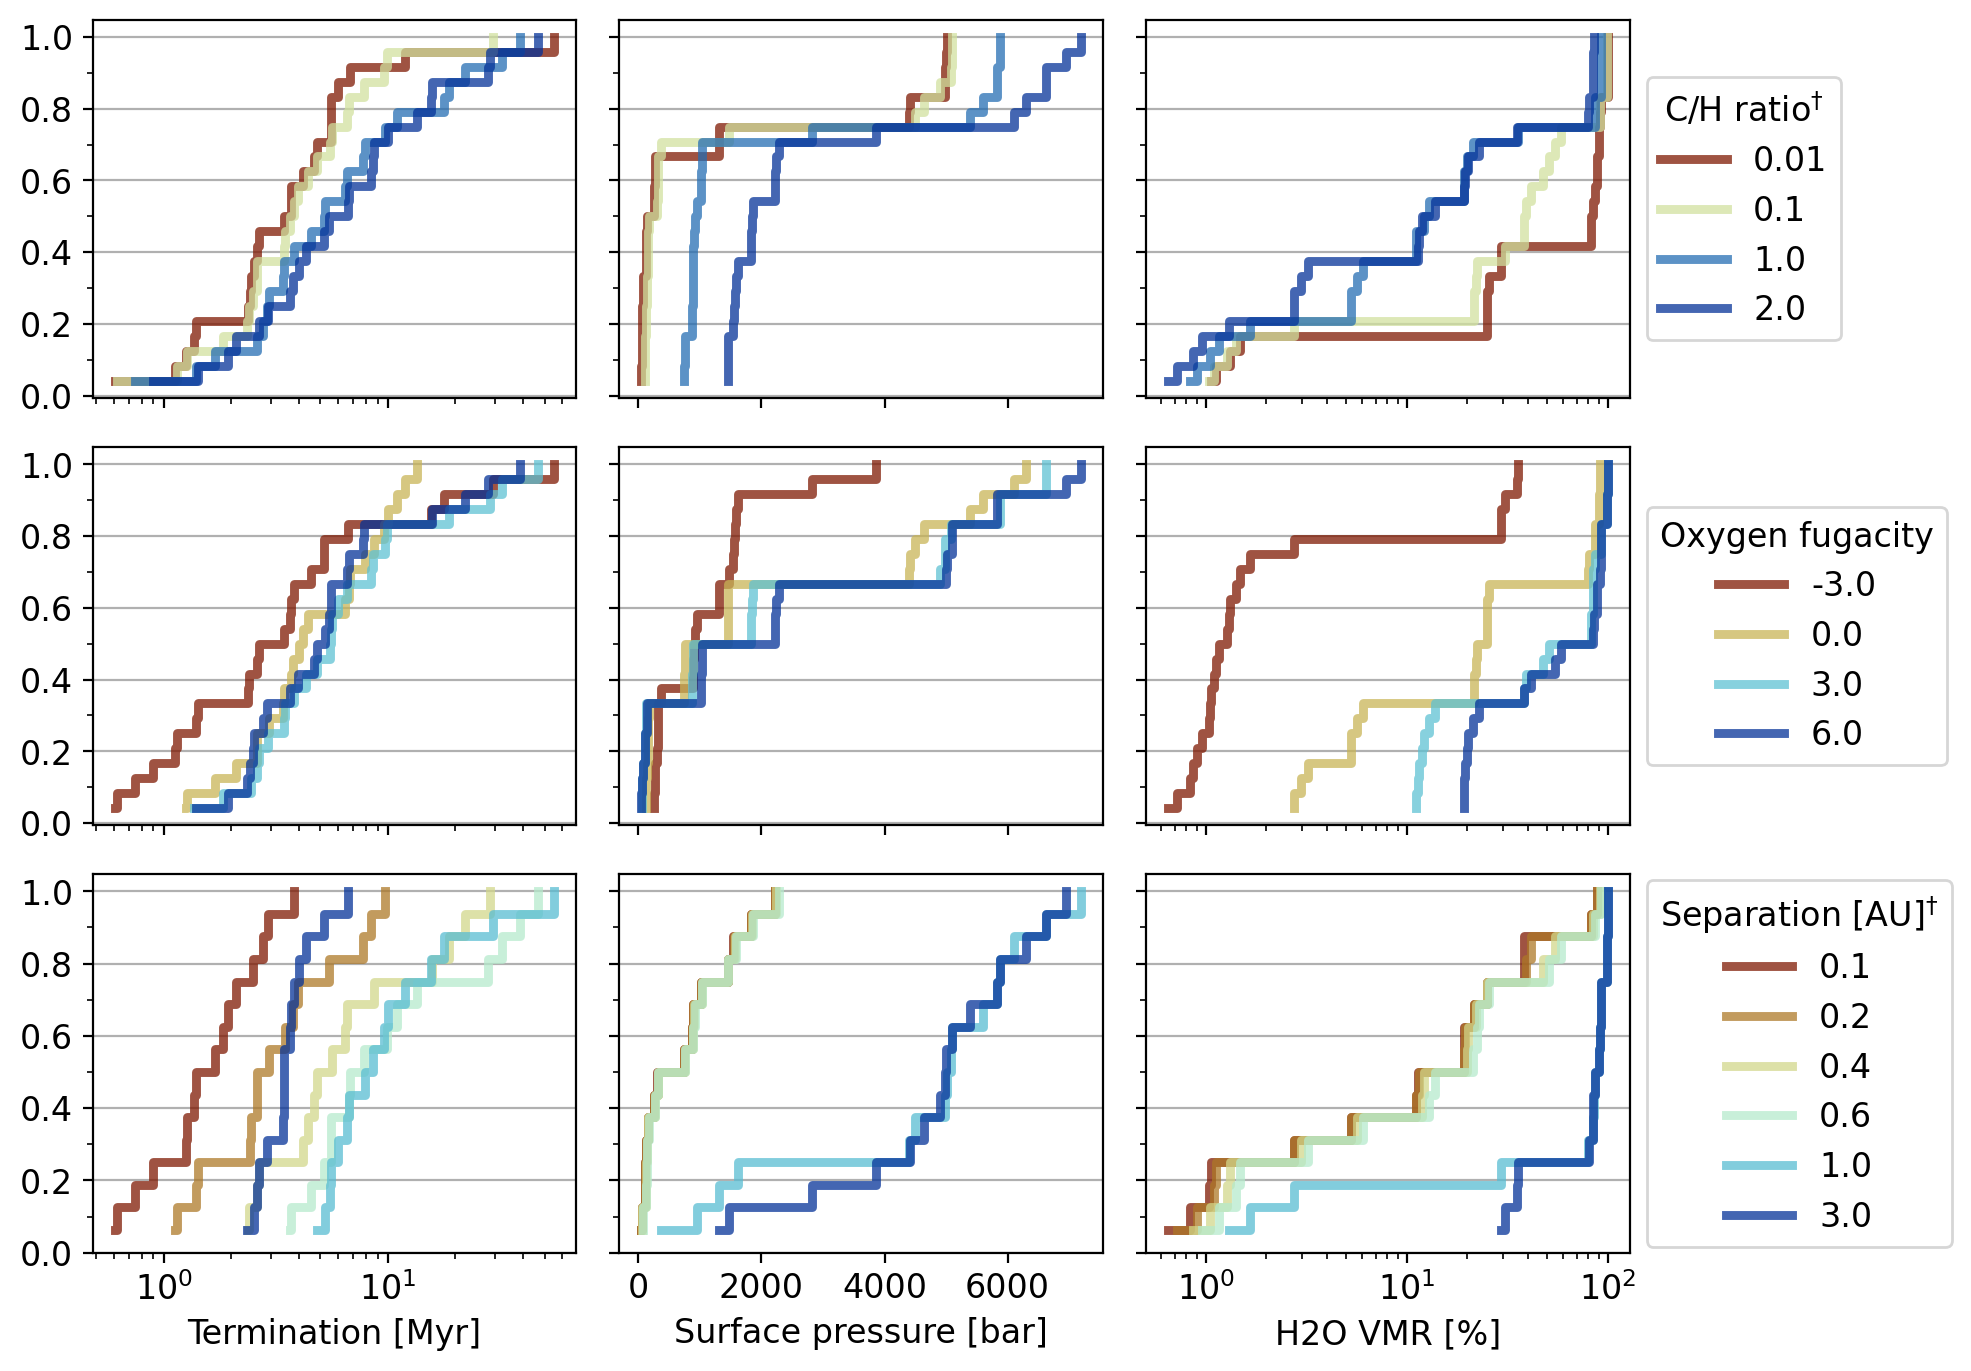

In [33]:
# Dependent variables
xs = [
    {
        "key":      "Time",
        "label":    "Termination [Myr]",
        "scale":    1.0e-6,
        "log":      True
    },
    {
        "key":      "P_surf",
        "label":    "Surface pressure [bar]",
        "scale":    1.0,
        "log":      False
    },
    {
        "key":      "H2O_mr",
        "label":    "H2O VMR [%]",
        "scale":    100.0,
        "log":      True
    }
]

# Independent variables
zs = [
    {
        "key":      "CH_ratio",
        "label":    "C/H ratio",
        "scale":    1.0,
        "log":      True,
        "cmap":     "roma"
    },
    {
        "key":      "fO2_shift_IW",
        "label":    "Oxygen fugacity",
        "scale":    1.0,
        "log":      False,
        "cmap":     "roma"
    },
    {
        "key":      "mean_distance",
        "label":    "Separation [AU]",
        "scale":    1.0,
        "log":      True,
        "cmap":     "roma"
    }
]

ecdf_many(xs,zs)